# How to create branches for parallel node execution

Parallel execution of nodes is essential to speed up overall graph operation. LangGraph offers native support for parallel execution of nodes, which can significantly enhance the performance of graph-based workflows. This parallelization is achieved through fan-out and fan-in mechanisms, utilizing both standard edges and [conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.add_conditional_edges). Below are some examples showing how to add create branching dataflows that work for you. 

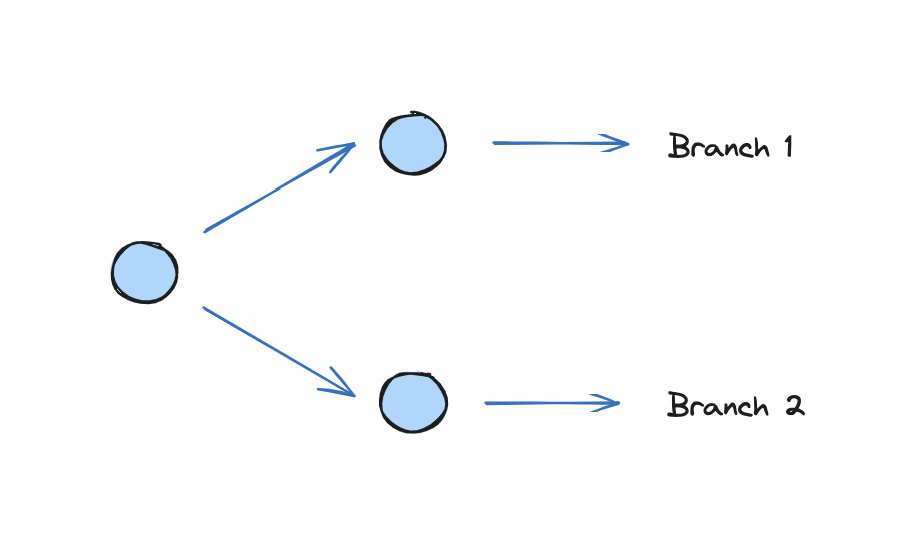

## Setup

First, let's install the required packages

In [2]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how LangSmith can help you <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Parallel node fan-out and fan-in

In this example, we fan out from `Node A` to `B and C` and then fan in to `D`. With our state, [we specify the reducer add operation](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). This will combine or accumulate values for the specific key in the State, rather than simply overwriting the existing value. For lists, this means concatenating the new list with the existing list. 

Note that LangGraph uses `Annotated` type to specify reducer functions for specific keys in the State: it maintains the original type (`list`) for type checking, but allows attaching the reducer function (`add`) to the type without changing the type itself.

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

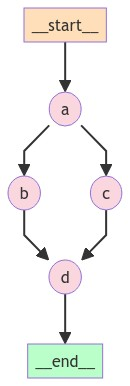

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

With the reducer, you can see that the values added in each node are accumulated.

In [3]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

<details class="note"> <summary>Exception handling?</summary>
 <p>LangGraph executes nodes within <a href="https://langchain-ai.github.io/langgraph/concepts/#core-design">"supersteps"</a>, meaning that while parallel branches are executed in parallel, the entire superstep is <b>transactional</b>. If any of these branches raises an exception, <b>none</b> of the updates are applied to the state (the entire superstep errors).<br><br>
 If you have error-prone (perhaps want to handle flakey API calls), LangGraph provides two ways to address this:<br>
 <ol>
  <li>You can write regular python code within your node to catch and handle exceptions.</li>
  <li>You can set a <b><a href="https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy">retry_policy</a></b> to direct the graph to retry nodes that raise certain types of exceptions. Only failing branches are retried, so you needn't worry about performing redundant work.</li>
</ol></p>
Together, these let you perform parallel execution and fully control exception handling.
</details>

## Parallel node fan-out and fan-in with extra steps

The above example showed how to fan-out and fan-in when each path was only one step. But what if one path had more than one step?

In [4]:
import operator
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

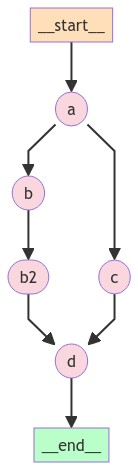

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Conditional Branching

If your fan-out is not deterministic, you can use [add_conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph.add_conditional_edges) directly.

If you have a known "sink" node that the conditional branches will route to afterwards, you can provide `then=<final-node-name>` when creating the conditional edges.

In [7]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


builder.add_edge("e", END)
graph = builder.compile()

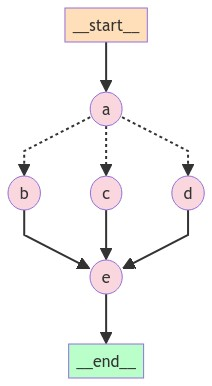

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': 'bc'}

In [10]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm D to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

## Stable Sorting

When fanned out, nodes are run in parallel as a single "superstep". The updates from each superstep are all applied to the state in sequence once the superstep has completed. 

If you need consistent, predetermined ordering of updates from a parallel superstep, you should write the outputs (along with an identifying key) to a separate field in your state, then combine them in the "sink" node by adding regular `edge`'s from each of the fanout nodes to the rendezvous point.

For instance, suppose I want to order the outputs of the parallel step by "reliability".

In [11]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph


def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.9))

builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.1))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.3))


def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    return {
        "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


builder.add_node("e", aggregate_fanout_values)


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

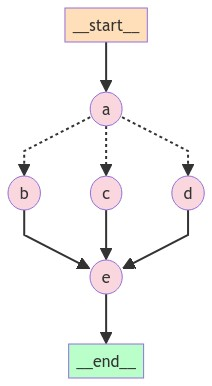

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to ["I'm A"] in parallel.
Adding I'm C to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm B"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'bc'}

In [14]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm D to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm D"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'cd'}